# Image Segmentation with Ivy UNet

Use the Ivy `UNet` model for image segmentation. \
Make sure you are using the GPU when using this notebook!

If you already have `Ivy` and `Ivy Models` installed you can skip this cell, but if you are using Colab, you will have to install `Ivy` and `Ivy Models` manually. You can do so by running the cell below ⬇️

Keep in mind that for the package to be available, you will have to click on **"Runtime > Restart Runtime"** 😄

In [ ]:
!pip install -q ivy
!pip install -q dm-haiku

# Using a stable commit from models repository to ensure compatibility with Ivy 😄
!pip install -q git+https://github.com/unifyai/models.git@6d6deebcebb191788a0f6e067b0a10871ce65d1c

exit()

## Imports

In [1]:
import ivy
import torch
import numpy as np

## Data Preparation

### Custom Preprocessing

In [2]:
# ref: https://github.com/milesial/Pytorch-UNet/blob/2f62e6b1c8e98022a6418d31a76f6abd800e5ae7/utils/data_loading.py#L65

def preprocess(mask_values, pil_img, scale, is_mask):
        w, h = pil_img.size
        newW, newH = int(scale * w), int(scale * h)
        assert newW > 0 and newH > 0, 'Scale is too small, resized images would have no pixel'
        pil_img = pil_img.resize((newW, newH), resample=Image.NEAREST if is_mask else Image.BICUBIC)
        img = np.asarray(pil_img)

        if is_mask:
            mask = np.zeros((newH, newW), dtype=np.int64)
            for i, v in enumerate(mask_values):
                if img.ndim == 2:
                    mask[img == v] = i
                else:
                    mask[(img == v).all(-1)] = i

            return mask

        else:
            if img.ndim == 2:
                img = img[np.newaxis, ...]
            else:
                img = img.transpose((2, 0, 1))

            if (img > 1).any():
                img = img / 255.0

            return img

### Load the image example 🖼️

In [3]:
# Preprocess image
from PIL import Image
filename = "models/images/car.jpg"
full_img = Image.open(filename)
torch_img = torch.from_numpy(preprocess(None, full_img, 0.5, False)).unsqueeze(0).to("cuda")

In [4]:
# Convert to ivy
ivy.set_backend("torch")
img = ivy.asarray(torch_img.permute((0, 2, 3, 1)), dtype="float32", device="gpu:0")
img_numpy = img.cpu().numpy()

### Visualise image

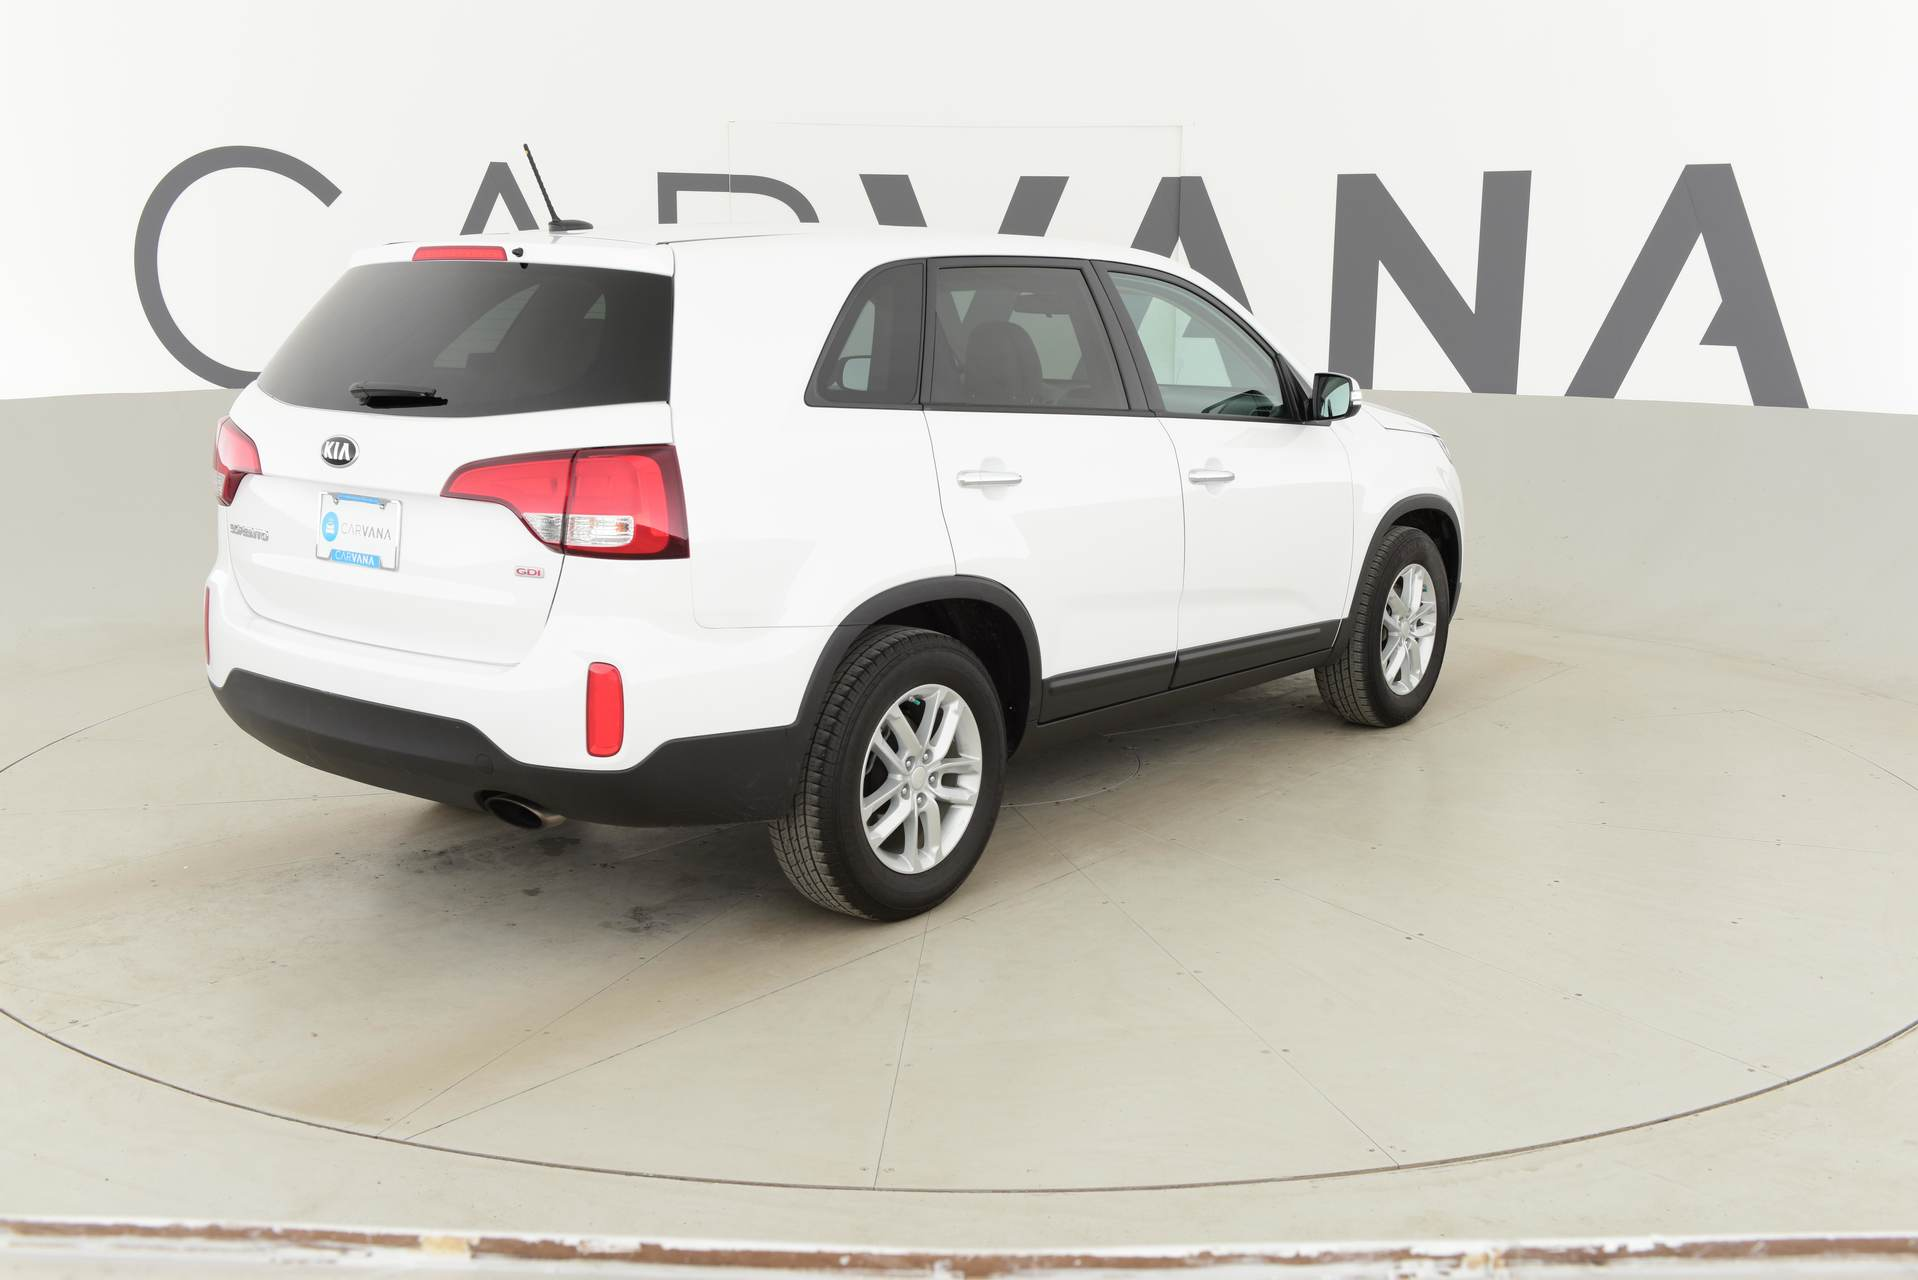

In [5]:
from IPython.display import Image as I, display
display(I(filename))

## Model Inference

### Initializing Native Torch UNet

In [ ]:
torch_unet = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana', pretrained=True, scale=1.0)
torch_unet.to("cuda")
torch_unet.eval()

### Initializing Ivy UNet with Pretrained Weights ⬇️

The model is then initialized with the Pretrained Weights when `pretrained=True` 🔗.

In [7]:
# load the unet model from ivy_models
import ivy_models
ivy_unet = ivy_models.unet_carvana(n_channels=3, n_classes=2, pretrained=True)

Compile the forward pass for efficiency.

In [ ]:
ivy_unet.compile(args=(img,))

### Custom masking function

In [9]:
# ref: https://github.com/milesial/Pytorch-UNet/blob/2f62e6b1c8e98022a6418d31a76f6abd800e5ae7/predict.py#L62

def mask_to_image(mask: np.ndarray, mask_values):
    if isinstance(mask_values[0], list):
        out = np.zeros((mask.shape[-2], mask.shape[-1], len(mask_values[0])), dtype=np.uint8)
    elif mask_values == [0, 1]:
        out = np.zeros((mask.shape[-2], mask.shape[-1]), dtype=bool)
    else:
        out = np.zeros((mask.shape[-2], mask.shape[-1]), dtype=np.uint8)

    if mask.ndim == 3:
        mask = np.argmax(mask, axis=0)

    for i, v in enumerate(mask_values):
        out[mask == i] = v

    return Image.fromarray(out)

### Use the model to segment your images 🚀

First, we will generate the reference mask from the [reference model](https://github.com/milesial/Pytorch-UNet).



1. Torch UNet

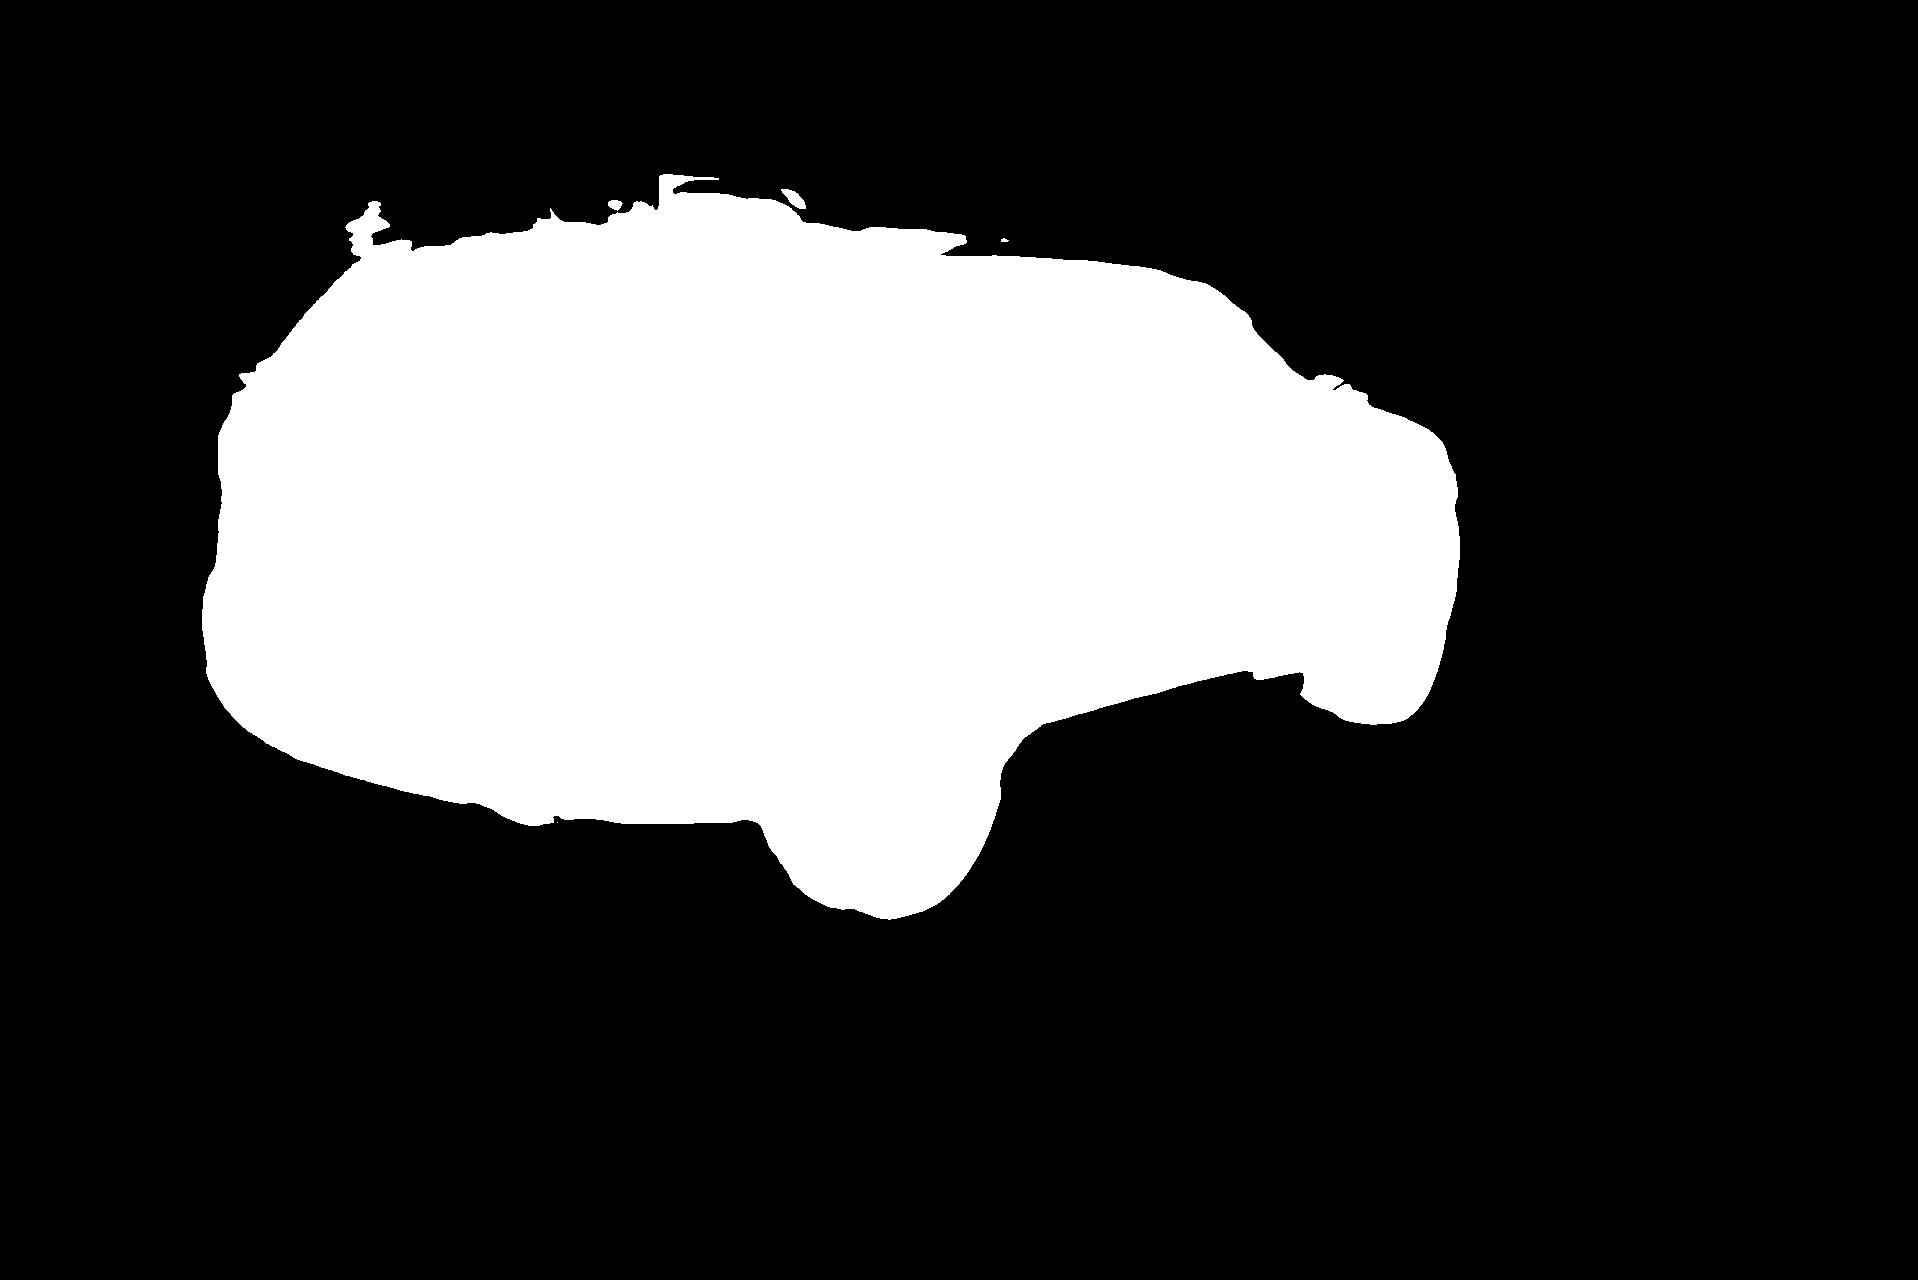

In [10]:
torch_output = torch_unet(torch_img.to(torch.float32))
torch_output = torch.nn.functional.interpolate(torch_output, (full_img.size[1], full_img.size[0]), mode="bilinear")
torch_mask = torch_output.argmax(axis=1)
torch_mask = torch_mask[0].squeeze().cpu().numpy()
torch_result = mask_to_image(torch_mask, [0,1])
torch_result.show()

Next we will generate the mask from the Ivy native implementation

2. Ivy UNet

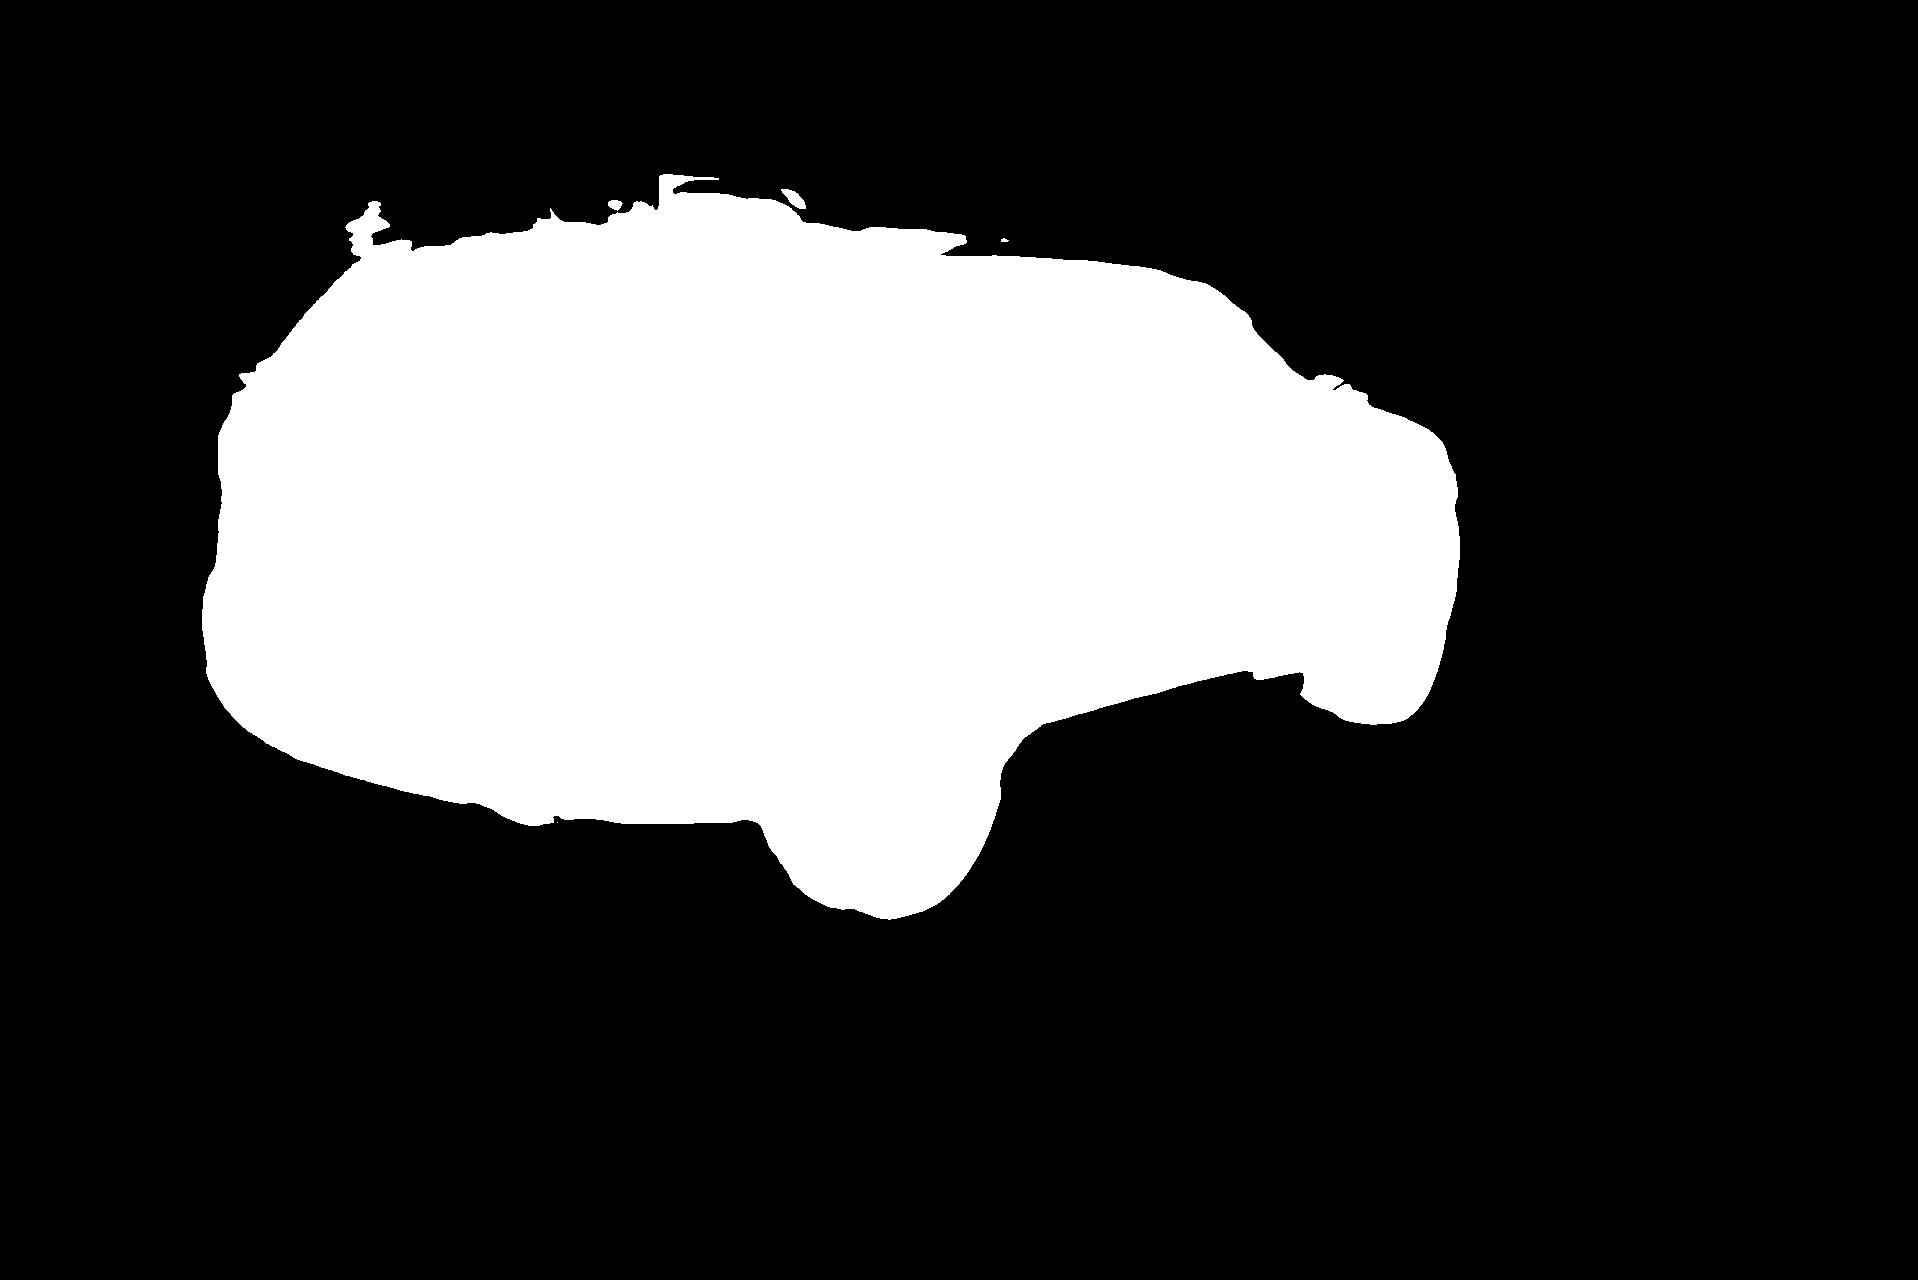

In [11]:
output = ivy_unet(img)
output = ivy.interpolate(output.permute((0, 3, 1, 2)), (full_img.size[1], full_img.size[0]), mode="bilinear")
mask = output.argmax(axis=1)
mask = ivy.squeeze(mask[0], axis=None).to_numpy()
result = mask_to_image(mask, [0,1])
result.show()

Great! The ivy native model and the torch model give the same result!

# TensorFlow backend

Let's look at using the TensorFlow backend.

In [12]:
import tensorflow as tf
ivy.set_backend("tensorflow")
ivy_unet = ivy_models.unet_carvana(n_channels=3, n_classes=2, pretrained=True)
img_tf = ivy.asarray(img_numpy)
ivy_unet = ivy.compile(ivy_unet, args=(img_tf,))

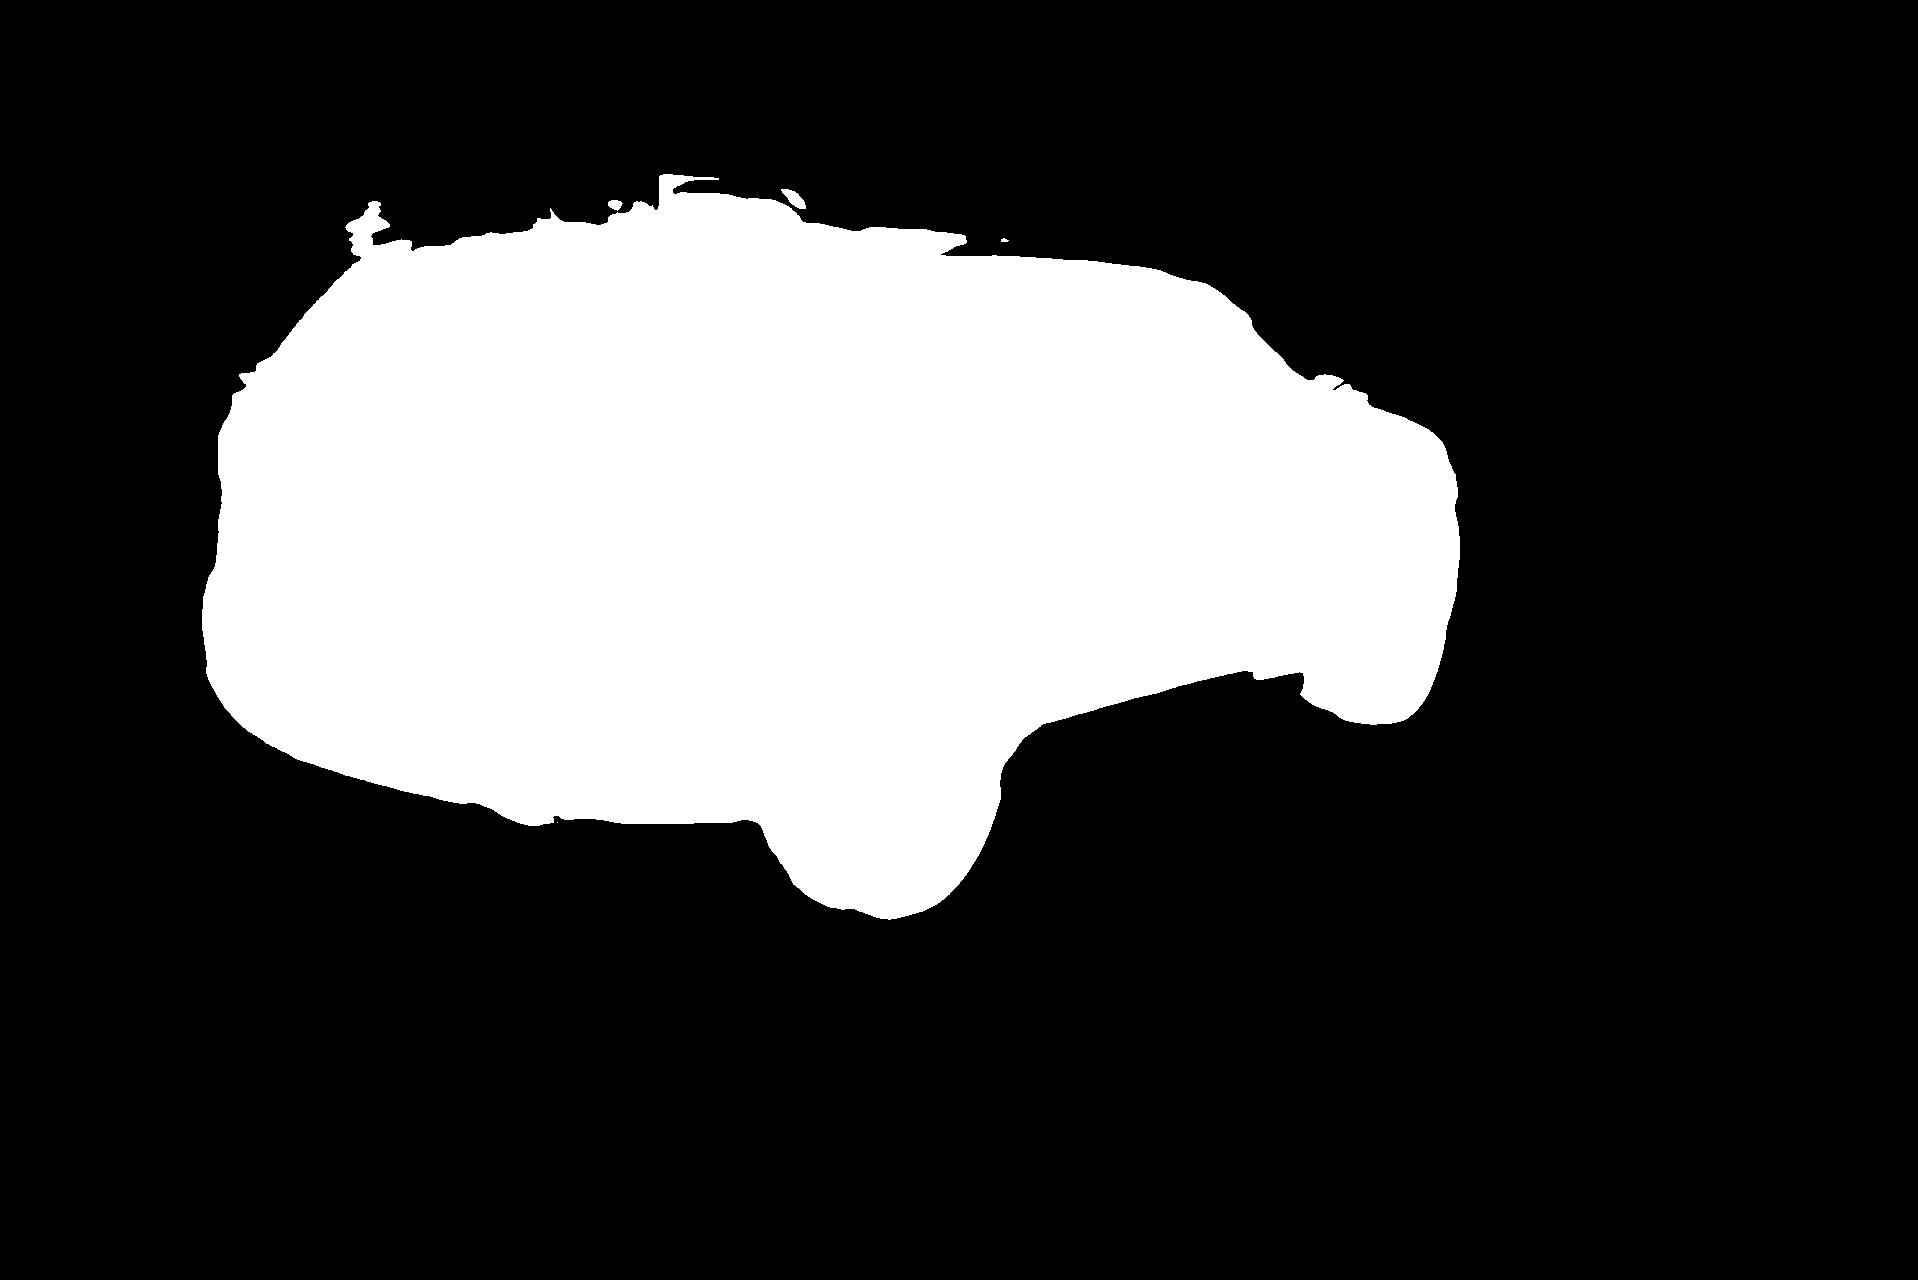

In [13]:
output = ivy_unet(img_tf)
output = ivy.interpolate(tf.transpose(output, (0, 3, 1, 2)), (full_img.size[1], full_img.size[0]), mode="bilinear")
mask = tf.math.argmax(output, axis=1)
mask = tf.squeeze(mask[0], axis=None).numpy()
result = mask_to_image(mask, [0,1])
result.show()

As expected, we ended up with the same mask as before. Note how with the TensorFlow backend, we were able to use TensorFlow native functions to do the post-processing.

# JAX

Next up is the JAX backend. We've used a lot of the notebook memory so far, so we'll free up some space.

In [14]:
del torch_unet
del ivy_unet
torch.cuda.empty_cache()

In [ ]:
import jax
import haiku as hk

jax.config.update('jax_enable_x64', True)
ivy.set_backend("jax")
ivy_unet = ivy_models.unet_carvana(n_channels=3, n_classes=2, pretrained=True)

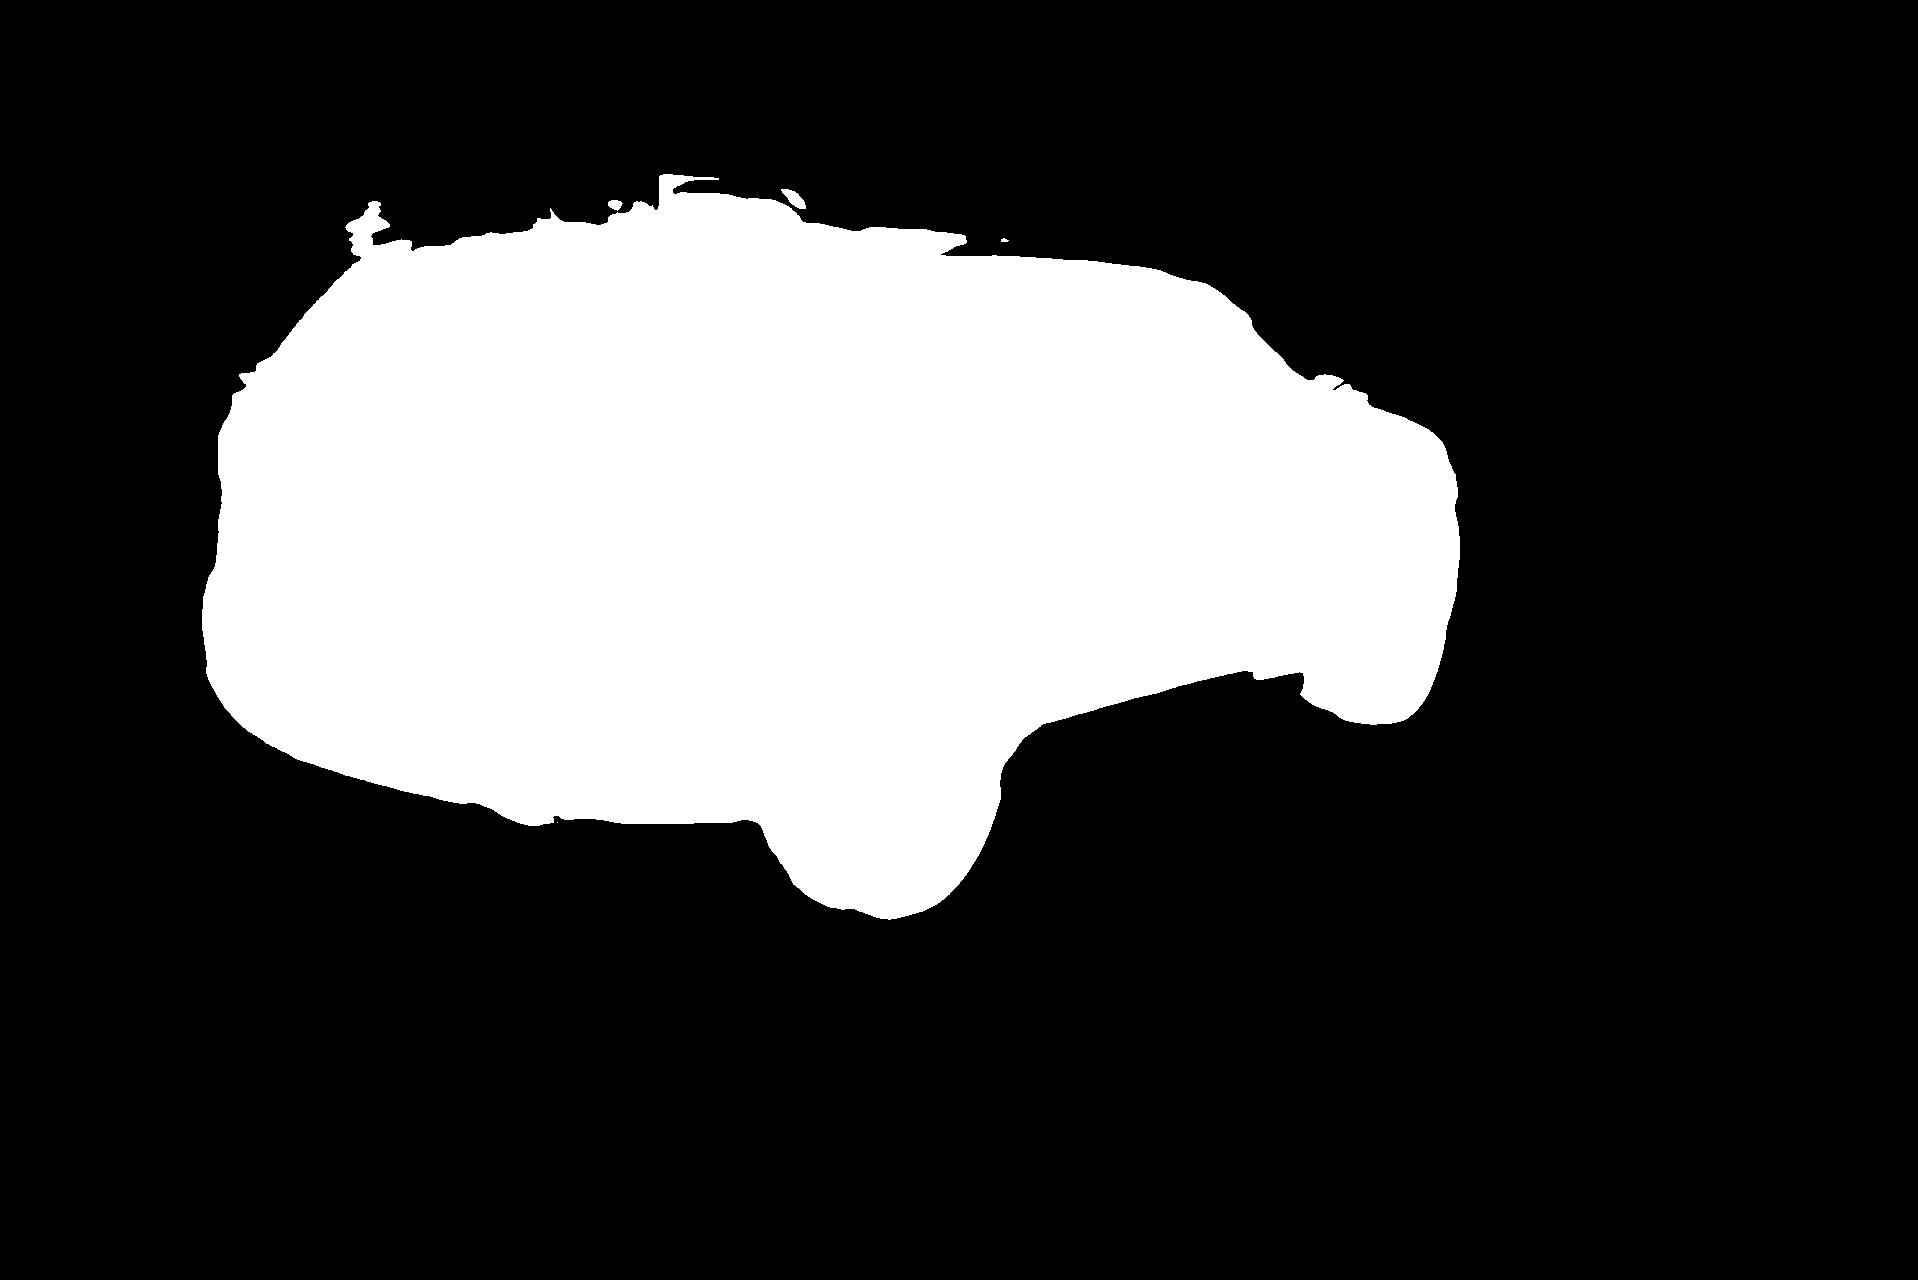

In [18]:
img_jax = ivy.asarray(img_numpy)
output = ivy_unet(img_jax)
output = ivy.interpolate(ivy.permute_dims(output, (0, 3, 1, 2)), (full_img.size[1], full_img.size[0]), mode="bilinear")
mask = output.argmax(axis=1)
mask = ivy.squeeze(mask[0], axis=None).to_numpy()
result = mask_to_image(mask, [0,1])
result.show()

Once again, we ended up with the same mask as in the reference torch implementation!

# Appendix: the Ivy native implementation of UNet

In [ ]:
class UNET(ivy.Module):
    def __init__(self, n_channels, n_classes, bilinear=False, v=None):
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.factor = 2 if bilinear else 1
        super(UNET, self).__init__(v=v)

    def _build(self, *args, **kwargs):
        self.inc = UNetDoubleConv(self.n_channels, 64)
        self.down1 = UNetDown(64, 128)
        self.down2 = UNetDown(128, 256)
        self.down3 = UNetDown(256, 512)
        self.down4 = UNetDown(512, 1024 // self.factor)
        self.up1 = UNetUp(1024, 512 // self.factor, self.bilinear)
        self.up2 = UNetUp(512, 256 // self.factor, self.bilinear)
        self.up3 = UNetUp(256, 128 // self.factor, self.bilinear)
        self.up4 = UNetUp(128, 64, self.bilinear)
        self.outc = UNetOutConv(64, self.n_classes)

    def _forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


class UNetDoubleConv(ivy.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.mid_channels = mid_channels if mid_channels else out_channels
        super(UNetDoubleConv, self).__init__()

    def _build(self, *args, **kwargs):
        self.double_conv = ivy.Sequential(
            ivy.Conv2D(
                self.in_channels, self.mid_channels, [3, 3], 1, 1, with_bias=False
            ),
            ivy.BatchNorm2D(self.mid_channels),
            ivy.ReLU(),
            ivy.Conv2D(
                self.mid_channels, self.out_channels, [3, 3], 1, 1, with_bias=False
            ),
            ivy.BatchNorm2D(self.out_channels),
            ivy.ReLU(),
        )

    def _forward(self, x):
        return self.double_conv(x)


class UNetDown(ivy.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        self.in_channels = in_channels
        self.out_channels = out_channels
        super().__init__()

    def _build(self, *args, **kwargs):
        self.maxpool_conv = ivy.Sequential(
            ivy.MaxPool2D(2, 2, 0), UNetDoubleConv(self.in_channels, self.out_channels)
        )

    def _forward(self, x):
        return self.maxpool_conv(x)


class UNetUp(ivy.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.bilinear = bilinear
        super().__init__()

    def _build(self, *args, **kwargs):
        if self.bilinear:
            self.up = ivy.interpolate(
                scale_factor=2, mode="bilinear", align_corners=True
            )
            self.conv = UNetDoubleConv(
                self.in_channels, self.out_channels, self.in_channels // 2
            )
        else:
            self.up = ivy.Conv2DTranspose(
                self.in_channels, self.in_channels // 2, [2, 2], 2, "VALID"
            )
            self.conv = UNetDoubleConv(self.in_channels, self.out_channels)

    def _forward(self, x1, x2):
        x1 = self.up(x1)
        # input is BHWC
        diff_H = x2.shape[1] - x1.shape[1]
        diff_W = x2.shape[2] - x1.shape[2]

        pad_width = (
            (0, 0),
            (diff_H - diff_H // 2, diff_H // 2),
            (diff_W // 2, diff_W - diff_W // 2),
            (0, 0),
        )

        x1 = ivy.constant_pad(x1, pad_width)
        x = ivy.concat((x2, x1), axis=3)
        return self.conv(x)


class UNetOutConv(ivy.Module):
    def __init__(self, in_channels, out_channels):
        self.in_channels = in_channels
        self.out_channels = out_channels
        super(UNetOutConv, self).__init__()

    def _build(self, *args, **kwargs):
        self.conv = ivy.Conv2D(self.in_channels, self.out_channels, [1, 1], 1, 0)

    def _forward(self, x):
        return self.conv(x)